### Monte Carlo for convergencse check of ACO and GA algorithms

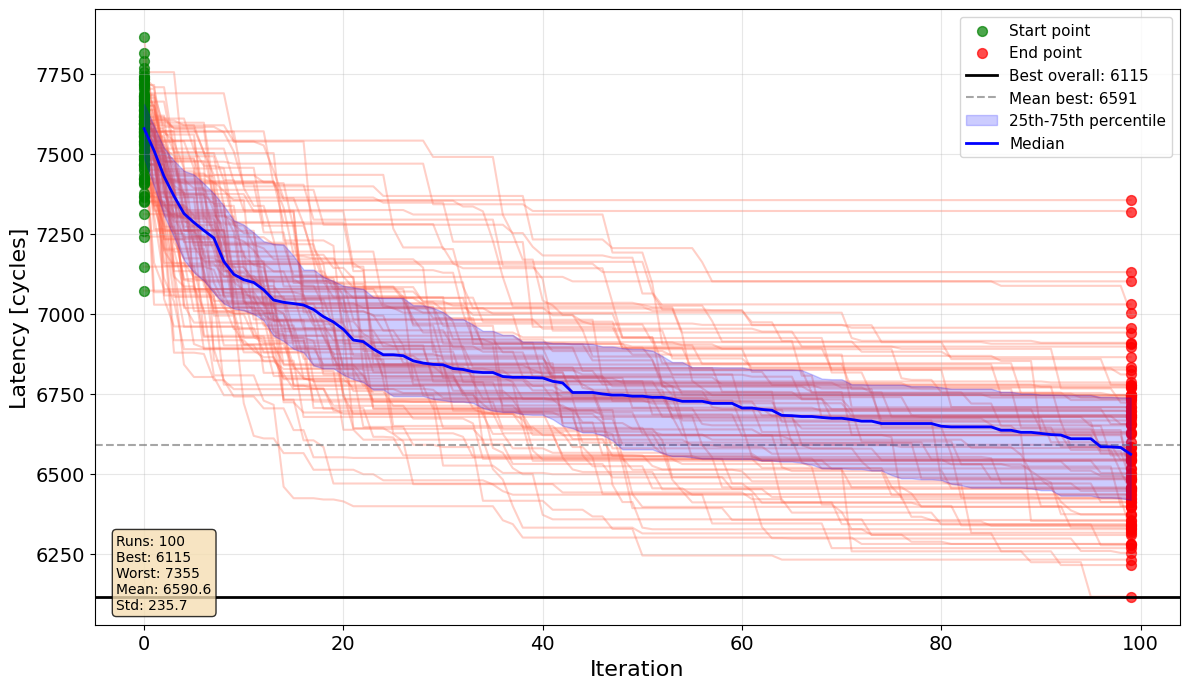


=== Summary Statistics ===
Successful runs: 100
Maximum iterations used: 100
Truncated to: 1000 iterations
Best latency found: 6115 cycles
Worst latency: 7355 cycles
Mean latency: 6590.6 cycles
Standard deviation: 235.7 cycles
Improvement range: 1240 cycles


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

absolute_bests_print = True
confidense_interval_print = True

#ACO MC LeNet 1k
#BASE_DIR = "../data/ACO_run_array_LeNet_1k_MC" 
#NAME_DIR = "ACO_LeNet4"

#GA MC LeNet 100 it
BASE_DIR = "../data/GA_MC_run_100_it_15_July" 
NAME_DIR = "GA_LeNet4"

folders = sorted([f for f in os.listdir(BASE_DIR) if f.startswith(NAME_DIR)])

# Set maximum number of iterations to use from each file
MAX_ITERATIONS = 1000  # Change this to your desired number

# Set global matplotlib parameters
plt.rcParams['axes.labelsize'] = 16      # x and y axis labels
plt.rcParams['xtick.labelsize'] = 14     # x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14     # y-axis tick labels
plt.rcParams['legend.fontsize'] = 11     # legend font size


# For collecting all best values per simulation
all_best_values = []
start_values = []
end_values = []
absolute_bests = []

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Track successful loads
successful_runs = 0

for folder in folders:
    path = os.path.join(BASE_DIR, folder)
    try:
        stats_path = os.path.join(path, "statistics.npy")
        stats = np.load(stats_path, allow_pickle=True).item()
        #line to print headers of stats
        #print(f"Keys in stats: {list(stats.keys())}")
        
        best_values = np.array(stats["best"])
        
        # Truncate to maximum iterations
        if len(best_values) > MAX_ITERATIONS:
            best_values = best_values[:MAX_ITERATIONS]
        
        absolute_best = stats["absolute_best"]
        
        # Handle different formats of absolute_best
        if isinstance(absolute_best, (list, tuple, np.ndarray)):
            abs_best_value = absolute_best[-1] if len(absolute_best) > 2 else absolute_best[0]
        else:
            abs_best_value = absolute_best

        start_values.append(best_values[0])
        end_values.append(best_values[-1])
        absolute_bests.append(abs_best_value)
        all_best_values.append(best_values)

        # Plot convergence curve
        ax.plot(best_values, color="tomato", alpha=0.3, linewidth=1.5, zorder=1)
        successful_runs += 1
        
    except Exception as e:
        print(f"Could not load stats from {path}: {e}")

# Find the maximum number of iterations across all runs (after truncation)
max_iterations = max(len(run) for run in all_best_values) if all_best_values else 0

# Only plot markers if we have data
if start_values and end_values:
    # Plot start and end markers for all runs
    iterations = range(len(start_values))
    ax.scatter(np.zeros(len(start_values)), start_values, 
            color='green', s=50, alpha=0.7, label=f"Start point")
    
    # For end values, use the actual final iteration index
    if all_best_values:
        final_iterations = [len(run) - 1 for run in all_best_values]
        ax.scatter(final_iterations, end_values, 
                color='red', s=50, alpha=0.7, label=f"End point")

# Plot reference lines
if absolute_bests:
    min_abs_best = min(absolute_bests)
    max_abs_best = max(absolute_bests)
    mean_abs_best = np.mean(absolute_bests)
    
    ax.axhline(min_abs_best, linestyle='-', color='black', linewidth=2, 
            label=f"Best overall: {min_abs_best:.0f}", zorder=2)
    ax.axhline(mean_abs_best, linestyle='--', color='gray', alpha=0.7,
            label=f"Mean best: {mean_abs_best:.0f}", zorder=2)


# Improve plot aesthetics
ax.set_xlabel("Iteration")
ax.set_ylabel("Latency [cycles]")
#ax.set_title(f"ACO Convergence Analysis ({successful_runs} runs)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Add statistics text box
if absolute_bests_print:
    stats_text = f"Runs: {successful_runs}\nBest: {min_abs_best:.0f}\nWorst: {max_abs_best:.0f}\nMean: {mean_abs_best:.1f}\nStd: {np.std(absolute_bests):.1f}"
    ax.text(0.02, 0.02, stats_text, transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='left', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    ax.legend(loc='best')
    
if confidense_interval_print:
    # Pad sequences to same length for percentile calculation
    max_len = max(len(run) for run in all_best_values)
    padded_runs = []
    for run in all_best_values:
        padded = np.full(max_len, run[-1])  # Pad with final value
        padded[:len(run)] = run
        padded_runs.append(padded)
    
    runs_array = np.array(padded_runs)
    percentile_25 = np.percentile(runs_array, 25, axis=0)
    percentile_75 = np.percentile(runs_array, 75, axis=0)
    median = np.percentile(runs_array, 50, axis=0)
    
    iterations = np.arange(max_len)
    ax.fill_between(iterations, percentile_25, percentile_75, 
                    alpha=0.2, color='blue', label='25th-75th percentile', zorder=2)
    ax.plot(median, color='blue', linewidth=2, label='Median', zorder=2)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Print summary statistics
if absolute_bests:
    print(f"\n=== Summary Statistics ===")
    print(f"Successful runs: {successful_runs}")
    print(f"Maximum iterations used: {max_iterations}")
    print(f"Truncated to: {MAX_ITERATIONS} iterations")
    print(f"Best latency found: {min_abs_best:.0f} cycles")
    print(f"Worst latency: {max_abs_best:.0f} cycles")
    print(f"Mean latency: {mean_abs_best:.1f} cycles")
    print(f"Standard deviation: {np.std(absolute_bests):.1f} cycles")
    print(f"Improvement range: {max_abs_best - min_abs_best:.0f} cycles")